# Arctic Oscillation Index Composite of Arctic Albedo
## Introduction

This notebook creates a composite of Arctic System Re-Analysis Version 2 ALBEDO variable. Monthly AO (Arctic Oscillation) index positive and negative modes are used to condition the composite. 
The index is described here: https://www.ncdc.noaa.gov/teleconnections/ao/

"The Arctic Oscillation (AO) is a large scale mode of climate variability, also referred to as the Northern Hemisphere annular mode. The AO is a climate pattern characterized by winds circulating counterclockwise around the Arctic at around 55°N latitude. When the AO is in its positive phase, a ring of strong winds circulating around the North Pole acts to confine colder air across polar regions. This belt of winds becomes weaker and more distorted in the negative phase of the AO, which allows an easier southward penetration of colder, arctic airmasses and increased storminess into the mid-latitudes."



### Imports

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import pandas as pd
import xesmf as xe


In [2]:
def regrid(ds, var, lat_step=0.1, lon_step=0.1):
    # Create new lons and lats on a regular grid
    new_lat=np.arange(-90,90.1,lat_step)
    new_lon=np.arange(0,360.1,lon_step)

    # Create an xarray.Dataset that defines the new grid
    ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)})
    
    # Regrid the data to the new grid 
    regridder = xe.Regridder(ds, ds_out, 'bilinear', reuse_weights=True)
    dr = regridder(ds).to_dataset(name=var)
    
    dr = dr.sel(lat=slice(0,90))

    return dr

### Read the AO index data

In [3]:
ao=xr.open_dataset('/home/ubuntu/indexes/ao.nc')
ao

<xarray.Dataset>
Dimensions:  (time: 850)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2020-10-01
Data variables:
    ao       (time) float64 ...

### Read the ASR Albedo anomalies

In [4]:
file='/home/ubuntu/asr15km.anl.2D.anoms.nc'
ds=xr.open_dataset(file)

### Prepare the AO index for comparison
* Select the ASR date range
* Separate the positive and negative modes

In [5]:
ao=ao.sel(time=slice('2000-01-01','2016-12-01'))

ao_pos=ao['ao'].where(ao['ao'] >= 0).dropna(dim='time')
ao_neg=ao['ao'].where(ao['ao'] < 0).dropna(dim='time')

### Select ASR Albedo anomalies for each mode to calculate composites

In [9]:
pos_albedo=ds['ALBEDO'].sel(time=ao_pos['time']).mean(dim='time')
neg_albedo=ds['ALBEDO'].sel(time=ao_neg['time']).mean(dim='time')

### Regrid both composites 

In [7]:
pos_albedo2 = regrid(pos_albedo, 'ALBEDO')

Create weight file: bilinear_720x720_1801x3601.nc


/home/ubuntu/anaconda3/envs/clim680-xesmf/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [8]:
neg_albedo2 = regrid(neg_albedo, 'ALBEDO')

Reuse existing file: bilinear_720x720_1801x3601.nc


### Positive AO Composite

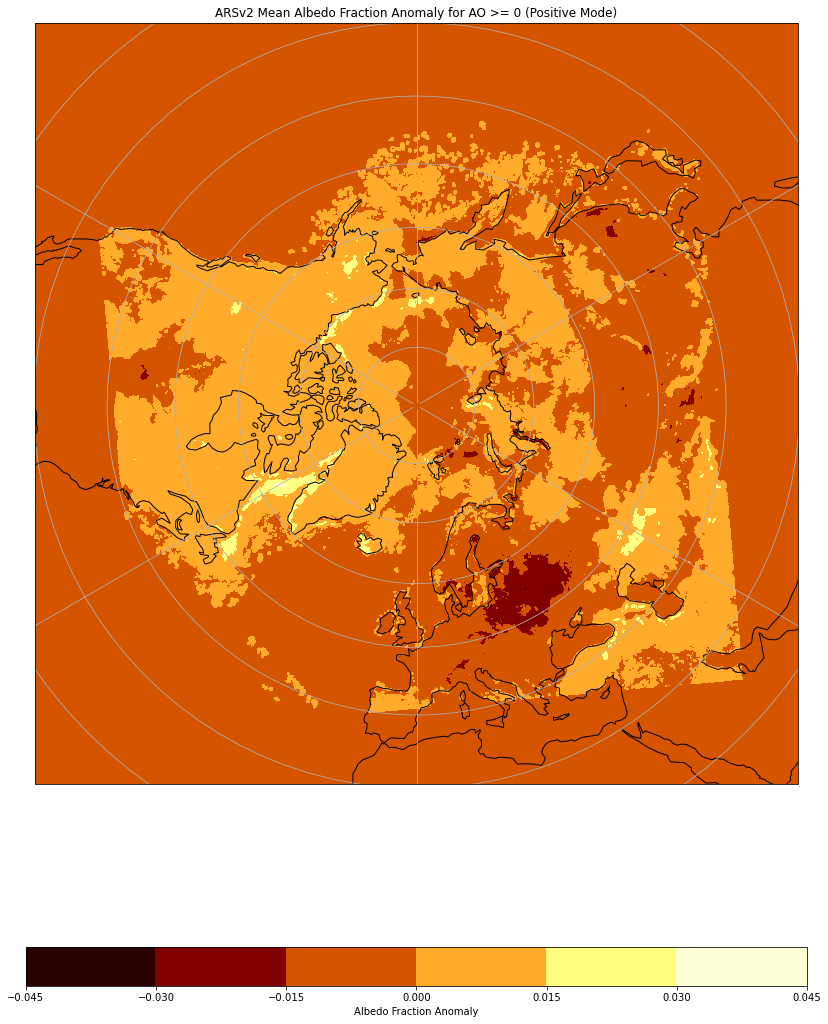

In [11]:
fig = plt.figure(figsize=(20,20))

# specify axis map projection
ax=plt.axes(projection=ccrs.NorthPolarStereo())

dr=pos_albedo2

# make a filled contour plot
cs=ax.contourf(dr['lon'], dr['lat'], 
            dr['ALBEDO'], 
            transform=ccrs.PlateCarree(),
            cmap='afmhot')

ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())


# add reference lines
ax.coastlines()
ax.gridlines()
# render_nps_grid_labels(ax)

cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,label='Albedo Fraction Anomaly')

plt.title('ARSv2 Mean Albedo Fraction Anomaly for AO >= 0 (Positive Mode)')
plt.show()

### Negative AO Composite

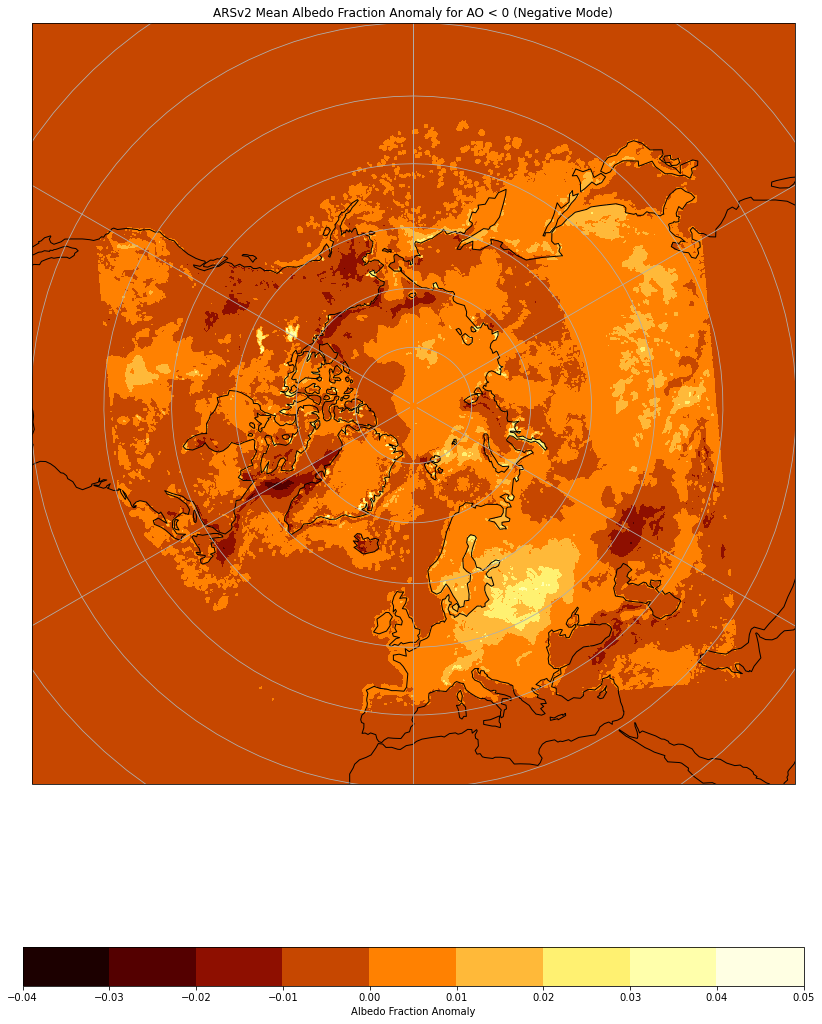

In [12]:
fig = plt.figure(figsize=(20,20))

# specify axis map projection
ax=plt.axes(projection=ccrs.NorthPolarStereo())

dr=neg_albedo2


# make a filled contour plot
cs=ax.contourf(dr['lon'], dr['lat'], 
            dr['ALBEDO'], 
            transform=ccrs.PlateCarree(),
            cmap='afmhot')

ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())


# add reference lines
ax.coastlines()
ax.gridlines()
# render_nps_grid_labels(ax)

cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,label='Albedo Fraction Anomaly')

plt.title('ARSv2 Mean Albedo Fraction Anomaly for AO < 0 (Negative Mode)')
plt.show()